# Exploratory study on existing early warning systems

## * Setup of the working environment *

### Import traditional Python packages

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime as dt, timedelta, date

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import time
import math
import json
import sys
import os

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Import custom Python modules

In [4]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from helpers.db_connector import MySQLConnector
from helpers.db_query import *

from helpers.data_process import *
from helpers.feature_extraction import *

from extractors.akpinar_et_al import AkpinarEtAl
from extractors.boroujeni_et_al import BoroujeniEtAl
from extractors.chen_cui import ChenCui
from extractors.he_et_al import HeEtAl
from extractors.lalle_conati import LalleConati
from extractors.lemay_doleck import LemayDoleck
from extractors.mbouzao_et_al import MbouzaoEtAl
from extractors.mubarak_et_al import MubarakEtAl
from extractors.wan_et_al import WanEtAl

from helpers.ml_utils import *

from helpers.time import *

## * Load the clickstream data *

Since Fall 2017, the stream of the EPFL's Linear Algebra course has been taught in a flipped format. The implementation of the flipped classroom was carried out in an incremental manner, as described below:

- **Year 2017-2018**: traditional manner (weeks 1-13) - flipped manner (week 14).
- **Year 2018-2019**: traditional manner (weeks 1-4, 10-14) - flipped manner (weeks 5-9).
- **Year 2019-2020**: traditional manner (weeks 1-4) - flipped manner (weeks 5-14).

In [7]:
rounds = ['Y2-2018-19', 'Y3-2019-20']

### Identifying Students


The flipped course was offered only to volunteering students. The volunteers were collectively assigned into either the experimental and the control group. A stratified random sampling based on gender and the prior background (secondary educational level) of students were used.

In [13]:
%time userData = getUserInfo(prior_knowledge=True)

CPU times: user 57.1 s, sys: 2.58 s, total: 59.7 s
Wall time: 2min 28s


The initial data of volunteers was cleaned, and some participants were removed before we analyzed the data:
- The volunteering students who have not been graded were removed. 
- The repeating students were filtered out, where repeating students are those accessing videos in two different years. 
- The less active students, i.e., those who have provided less 60 interactions in the platform, were removed. 

Given that the Y1-2017-2018 round included only one week in a flipped classroom setting, we will remove the students of that round.  

In [14]:
userData = userData[userData['Round'].isin(rounds)]

Some of the statistics on the user data are provided below. 

In [15]:
"Number of students:", len(userData)

('Number of students:', 214)

#### Exam Records

In [8]:
%time examData = getExamInfo()

CPU times: user 58 s, sys: 2.85 s, total: 1min
Wall time: 1min 57s


In [9]:
examData = examData[examData['Round'].isin(rounds)]

In [19]:
examData = examData[examData['AccountUserID'].isin(userData['AccountUserID'])]

In [20]:
"Number of graded students:", len(examData)

('Number of graded students:', 214)

## * Cross validation of early warning systems *

#### Parameters

In [22]:
mode = 'random'
task = 'binary'
ratio = 80
start, end, step = 5, 15, 1
iterations = 3

In [23]:
weeks = np.arange(start + 1, end, step)

#### Feature Sets

In [ ]:
featureLabels = [AkpinarEtAl(), BoroujeniEtAl(), ChenCui(), HeEtAl(), LalleConati(), LemayDoleck()]

In [24]:
featureSets = loadFeatureSets(mode, task, ratio, start, end, step)

> Found features for this experimental setting in ../data/feature_sets/feature_sets_random_binary_80_5-15-1.pkl


#### Models and Metrics

In [49]:
evaluation_metrics = {
    'acc': accuracy_score,
    'f1': f1_score,
    'p': precision_score, 
    'r': recall_score,
    'tp': tp,
    'tn': tn,
    'fp': fp,
    'fn': fn
}

In [25]:
trainedModels = loadTrainedModels(mode, task, ratio, start, end, step)

> Found models for this experimental setting in ../data/trained_models/trained_models_random_binary_80_5-15-1.pkl


In [47]:
x_train_idx, x_test_idx, y_train, y_test = getTrainTestData(examData, mode, task, ratio / 100.0)

> Binarizing student grades: [(0, 80), (1, 134)]
> Spitting the whole student population randomly: Train 171 [(0, 64), (1, 107)] - Test 43 [(0, 16), (1, 27)]


In [119]:
feature_labels = ['lalle_conati', 'boroujeni_et_al']
boroujeni_labels = ["peakDayHour", "peakWeekDay", "weeklySimilarity1", "weeklySimilarity2", 
                    "weeklySimilarity3", "freqDayHour", "freqWeekDay", "freqWeekHour", "nbQuiz", 
                    "propQuiz", "intervalVideoQuiz", "semesterRepartitionQuiz"]
lalle_conati_labels = ["totalViews", "avgWeeklyPropWatched", "stdWeeklyPropWatched", "avgWeeklyPropReplayed", 
                       "stdWeeklyPropReplayed", "avgWeeklyPropInterrupted", "stdWeeklyPropInterrupted", 
                       "totalActions", "freqAllActions", "freqPlay", "freqPause", "freqSeekBackward",
                       "freqSeekForward", "freqSpeedChange", "freqStop", "avgPauseDuration", "stdPauseDuration",
                       "avgSeekLength", "stdSeekLength", "avgTimeSpeedingUp", "stdTimeSpeedingUp"]
feature_names = lalle_conati_labels + boroujeni_labels

In [236]:
def concat_features(featureSets, train_idx, test_idx):
    #Concatenate feature vectors from different papers into a single one
    features = {}
    for wid in weeks:
        features[wid] = {}
        features[wid]['Train'] = np.hstack([featureSets[ffunc][wid][train_idx]  for ffunc in feature_labels])
        features[wid]['Test'] = np.hstack([featureSets[ffunc][wid][test_idx]  for ffunc in feature_labels])
    print("Number of features:",features[wid]['Train'].shape[1])
    return features

In [237]:
features = concat_features(featureSets, x_train_idx, x_test_idx)

Number of features: 33


In [219]:
def fit_lasso(features, y_train, y_test):
    metrics = []
    coefs = []
    for wid in weeks:
        x_train = features[wid]['Train']
        x_test = features[wid]['Test']
        for reg in np.linspace(0.001, 0.2, 20):
            lasso = LogisticRegression(penalty='l1',solver='liblinear', C=reg)
            lasso.fit(x_train, y_train)
            curr = [wid, reg]
            for emid, mfunc in evaluation_metrics.items():
                val = mfunc(lasso.predict(x_test), y_test)
                curr.append(val)
            curr.append(np.sum(abs(lasso.coef_) > 0))
            metrics.append(curr)
            coefs.append(list(lasso.coef_[0]))
            cols = ['week', 'regularization'] + list(evaluation_metrics.keys()) + ['nb_coef_used']
    return pd.DataFrame(metrics, columns=cols), coefs

### Metrics of each week for different regularizations

In [220]:
metrics, coefs = fit_lasso(features, y_train, y_test)
metrics[metrics.week == 8]

,week,regularization,acc,f1,p,r,tp,tn,fp,fn,nb_coef_used
40,8,0.001000,0.627907,0.771429,1.000000,0.627907,27,0,0,16,2
41,8,0.011474,0.651163,0.782609,1.000000,0.642857,27,1,0,15,6
42,8,0.021947,0.651163,0.782609,1.000000,0.642857,27,1,0,15,11
43,8,0.032421,0.674419,0.787879,0.962963,0.666667,26,3,1,13,11
44,8,0.042895,0.674419,0.787879,0.962963,0.666667,26,3,1,13,11
45,8,0.053368,0.697674,0.800000,0.962963,0.684211,26,4,1,12,11
46,8,0.063842,0.651163,0.761905,0.888889,0.666667,24,4,3,12,12
47,8,0.074316,0.651163,0.761905,0.888889,0.666667,24,4,3,12,11
48,8,0.084789,0.651163,0.761905,0.888889,0.666667,24,4,3,12,11
49,8,0.095263,0.651163,0.761905,0.888889,0.666667,24,4,3,12,11


### Best metrics per week

In [221]:
best_metrics_per_week = metrics.sort_values(by='f1', ascending=False).drop_duplicates(subset=['week'])\
                                .sort_values(by='week')
best_metrics_per_week

,week,regularization,acc,f1,p,r,tp,tn,fp,fn,nb_coef_used
1,6,0.011474,0.674419,0.794118,1.000000,0.658537,27,2,0,14,7
22,7,0.021947,0.651163,0.782609,1.000000,0.642857,27,1,0,15,8
45,8,0.053368,0.697674,0.800000,0.962963,0.684211,26,4,1,12,11
62,9,0.021947,0.627907,0.771429,1.000000,0.627907,27,0,0,16,9
91,10,0.116211,0.651163,0.776119,0.962963,0.650000,26,2,1,14,14
106,11,0.063842,0.674419,0.794118,1.000000,0.658537,27,2,0,14,11
124,12,0.042895,0.674419,0.787879,0.962963,0.666667,26,3,1,13,10
142,13,0.021947,0.627907,0.771429,1.000000,0.627907,27,0,0,16,9
160,14,0.001000,0.627907,0.771429,1.000000,0.627907,27,0,0,16,2


In [222]:
def best_coefs(best_metrics, coefs):
    named_coefs = pd.DataFrame(coefs, columns=lalle_conati_labels + boroujeni_labels)
    best_coefs = best_metrics.merge(named_coefs, left_index=True, right_index=True)[feature_names]
    best_coefs.index = weeks
    best_coefs = best_coefs.transpose()
    best_coefs['abs_sum'] = abs(best_coefs).sum(axis=1)
    best_coefs = best_coefs[best_coefs.abs_sum > 0] #Only keep features with non null coefs
    return best_coefs.sort_values(by="abs_sum", ascending=False)

### Features ordered by their contribution 

We can notice that even though the first is PDH, its main weight contribution comes from a single week, the 8-th week.

In [223]:
best_coefs_per_week = best_coefs(best_metrics_per_week, coefs)
best_coefs_per_week

,6,7,8,9,10,11,12,13,14,abs_sum
peakDayHour,0.000000,0.000000,0.142401,0.000000,0.067109,0.034226,0.000000,0.000000,0.000000,0.243737
totalViews,0.013448,0.045551,0.024939,0.022044,0.021684,0.020188,0.023339,0.014935,0.000000,0.186128
avgPauseDuration,-0.004170,-0.005361,-0.024538,-0.006219,-0.011886,-0.008696,-0.009895,0.000000,0.000000,0.070765
freqDayHour,0.000000,0.000000,0.000000,0.007427,0.005753,0.012294,0.021752,0.013850,0.000000,0.061076
freqWeekDay,0.000000,0.000000,0.000000,0.000000,-0.053774,0.000000,0.000000,0.000000,0.000000,0.053774
nbQuiz,0.000000,-0.006222,-0.005036,-0.004788,-0.003129,-0.005209,-0.005815,-0.006798,0.000000,0.036997
semesterRepartitionQuiz,0.004241,0.000000,-0.006631,0.000000,-0.000646,-0.008706,-0.006956,-0.008168,0.000000,0.035348
stdSeekLength,-0.001628,0.000000,0.003238,0.001801,-0.000180,0.002477,0.002616,0.004015,0.000000,0.015955
avgSeekLength,0.000000,-0.000133,-0.004239,-0.002714,0.000000,-0.002757,-0.003118,-0.001543,0.000000,0.014505
stdPauseDuration,0.004070,0.000704,-0.003065,0.000000,-0.003437,0.000000,-0.002906,0.000000,0.000000,0.014182


## Visualizations

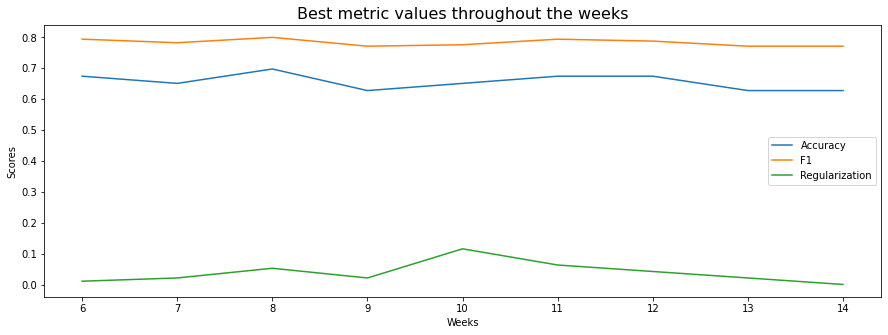

In [245]:
plt.figure(figsize=(15,5))
plt.plot(best_metrics_per_week.week,best_metrics_per_week.acc, label="Accuracy");
plt.plot(best_metrics_per_week.week, best_metrics_per_week.f1, label="F1");
plt.plot(best_metrics_per_week.week, best_metrics_per_week.regularization, label="Regularization");
plt.legend()
plt.title("Best metric values throughout the weeks", fontSize=16)
plt.xlabel("Weeks")
plt.ylabel("Scores");


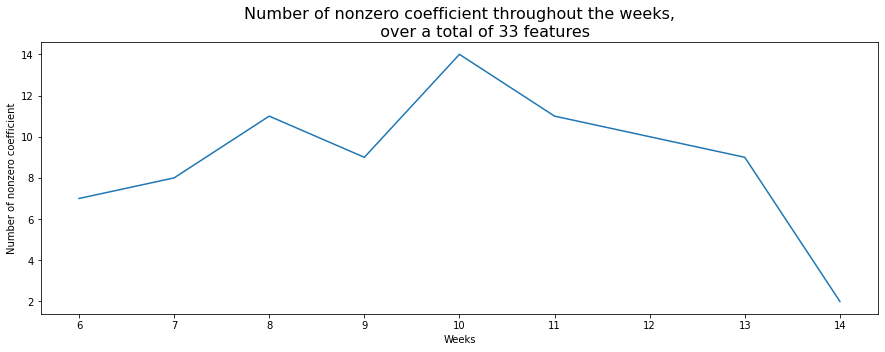

In [246]:
plt.figure(figsize=(15,5))
sns.lineplot(x=best_metrics_per_week.week, y=best_metrics_per_week.nb_coef_used);
plt.title("""Number of nonzero coefficient throughout the weeks,
          over a total of 33 features""", fontSize=16)
plt.xlabel("Weeks")
plt.ylabel("Number of nonzero coefficient");

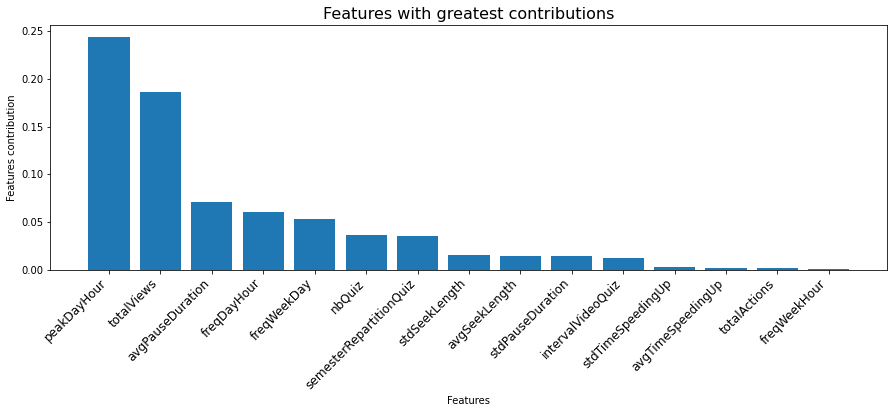

In [257]:
fig = plt.figure(figsize=(15,5))
plt.bar(best_coefs_per_week.index, best_coefs_per_week.abs_sum)
plt.xticks(fontSize=12)
fig.autofmt_xdate(rotation=45)
plt.title("""Features with greatest contributions""", fontSize=16)
plt.xlabel("Features")
plt.ylabel("Features contribution");